In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import scipy.interpolate
import sys
import functools
import time as pytime
import os
import math
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
from backend import jnp, conditional_decorator, jit, use_jax, fori_loop, put, cross, dot, sign, presfun, iotafun
from backend import get_needed_derivatives, unpack_x, rms, jacfwd, jacrev

from zernike import ZernikeTransform, get_zern_basis_idx_dense, get_double_four_basis_idx_dense, axis_posn, symmetric_x
from zernike import fringe_to_lm, lm_to_fringe, zern, zern_radial, fourzern, eval_double_fourier, double_fourier_basis
from init_guess import get_initial_guess_scale_bdry
from boundary_conditions import compute_bc_err_four, compute_bc_err_RZ, compute_lambda_err, format_bdry, compute_bc_err_four_sfl
from plotting import plot_IC, plot_fb_err, plot_coord_surfaces, plot_coeffs
from field_components import compute_coordinate_derivatives, compute_jacobian, compute_covariant_basis
from field_components import compute_B_field, compute_J_field, compute_contravariant_basis
from objective_funs import compute_force_error_nodes, compute_force_error_RphiZ, compute_force_error_RddotZddot, get_equil_obj_fun
from nodes import get_nodes_pattern, get_nodes_surf
from input_output import read_input, output_to_file
from gfile_helpers import read_gfile, write_gfile, plot_gfile
from zernike import four, zern, zern_radial, zern_azimuthal, four_toroidal, zern_radial_r, zern_radial_rr, zern_radial_rrr
from zernike import zern_azimuthal, zern_azimuthal_v, zern_azimuthal_vv, zern_azimuthal_vvv
from zernike import four_toroidal, four_toroidal_z
from scipy.special import factorial

/home/fouriest/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Using JAX float64


In [3]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 1
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
# rcParams['axes.prop_cycle'] =  color_cycle
rcParams['axes.prop_cycle'] =  color_cycle + dash_cycle

labelsize=10
ticksize=8

In [4]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [5]:
inputs = read_input('./benchmarks/DESC/HELIOTRON.input')
print(inputs)
# inputs['Mpol'] = np.array([6,8,10])
# inputs['Ntor'] = np.array([0,2,4])
# inputs['bdry_ratio'] = np.array([0,.5,1])
# inputs['ftol'] = [1e-6]
# inputs['xtol'] = [1e-6]
# inputs['gtol'] = [1e-6]
# inputs['max_nfev'] = [50]

{'stell_sym': 1, 'NFP': 19, 'Psi_lcfs': 1.0, 'Mpol': array([ 6,  6,  6,  6,  7,  8,  9, 10, 11, 12]), 'Ntor': array([0, 1, 1, 1, 2, 2, 2, 2, 2, 2]), 'Mnodes': array([ 9,  9,  9,  9, 11, 12, 14, 15, 17, 18]), 'Nnodes': array([0, 2, 2, 2, 3, 3, 3, 3, 3, 3]), 'bdry_ratio': array([0.  , 0.33, 0.67, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'pres_ratio': array([0.  , 0.  , 0.  , 0.  , 0.33, 0.67, 1.  , 1.  , 1.  , 1.  ]), 'zeta_ratio': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.67, 1.  ]), 'errr_ratio': array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001]), 'ftol': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06]), 'xtol': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06]), 'gtol': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06]), 'nfev': array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]), 'verbose': 2, '

precomputing Fourier-Zernike basis
computing initial guess


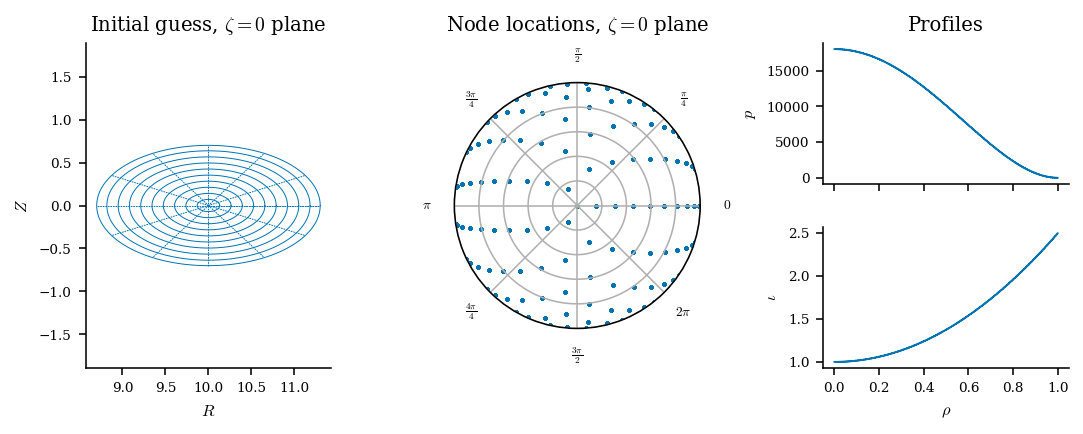

In [6]:
stell_sym      = inputs['stell_sym']
M              = inputs['Mpol'][-1]
N              = inputs['Ntor'][-1]
Mnodes         = inputs['Mnodes'][-1]
Nnodes         = inputs['Nnodes'][-1]
NFP            = inputs['NFP']
Psi_lcfs       = inputs['Psi_lcfs']
errr_mode      = inputs['errr_mode']
bdry_mode      = inputs['bdry_mode']
node_mode      = inputs['node_mode']
bdry_ratio     = inputs['bdry_ratio'][-1]
pres_ratio     = inputs['pres_ratio'][-1]
zeta_ratio     = inputs['zeta_ratio'][-1]
errr_ratio     = inputs['errr_ratio'][-1]
presfun_params = inputs['cP']
iotafun_params = inputs['cI']
axis           = inputs['axis']  # TODO: use this for computing initial guess
bdry           = inputs['bdry']

cP = presfun_params
cI = iotafun_params
M=10
N=10
Mnodes = 10
Nnodes = 10
bdry_mode_in = bdry_mode

# weights
weights = {'F':1e6,     # force balance error
           'B':1e4,     # error in bdry
           'L':1e4}     # error in sum lambda_mn



bdry_pol, bdry_tor, bdryR, bdryZ = format_bdry(M, N, NFP, bdry, bdry_mode_in, bdry_mode)
nodes,volumes = get_nodes_pattern(Mnodes,Nnodes,NFP,surfs=node_mode)

# interpolator
print('precomputing Fourier-Zernike basis')
derivatives = get_needed_derivatives('all')
zern_idx = get_zern_basis_idx_dense(M,N)
lambda_idx = get_double_four_basis_idx_dense(M,N)
zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)

bdry_nodes, _ = get_nodes_surf(Mnodes,Nnodes,NFP,surf=1.0)
bdry_zernt = ZernikeTransform(bdry_nodes,zern_idx,NFP,[0,0,0])

if stell_sym:
    sym_mat = symmetric_x(M,N)
else:
    sym_mat = np.eye(2*len(zern_idx) + len(lambda_idx))


# initial guess
print('computing initial guess')
cR_init,cZ_init = get_initial_guess_scale_bdry(axis,bdry,zern_idx,NFP,mode=bdry_mode,rcond=1e-6)
cL_init = np.zeros(len(lambda_idx))
x_init = jnp.concatenate([cR_init,cZ_init,cL_init])
x_init = jnp.matmul(sym_mat.T,x_init)

x = x_init



fig, ax = plot_IC(cR_init, cZ_init, zern_idx, NFP, nodes, presfun_params, iotafun_params)

In [7]:
equil_obj,callback = get_equil_obj_fun(stell_sym,errr_mode,bdry_mode,M,N,
                     NFP,zernt,bdry_zernt,zern_idx,lambda_idx,bdry_pol,bdry_tor,nodes,volumes)
args = [bdryR,bdryZ,cP,cI,Psi_lcfs,bdry_ratio,pres_ratio,zeta_ratio,errr_ratio]
# obj_jac  = jacfwd(equil_obj,argnums=0)
# Jx = obj_jac(x,*args)
cR,cZ,cL = unpack_x(np.matmul(sym_mat,x),len(zern_idx))

compute_coordinate_derivatives_jit = jit(compute_coordinate_derivatives,static_argnums=(2,))
compute_covariant_basis_jit        = jit(compute_covariant_basis)
compute_jacobian_jit               = jit(compute_jacobian)
compute_contravariant_basis_jit    = jit(compute_contravariant_basis,static_argnums=(3,))
compute_B_field_jit                = jit(compute_B_field,static_argnums=(4,))
compute_J_field_jit                = jit(compute_J_field,static_argnums=(6,))
compute_force_error_nodes_jit      = jit(compute_force_error_nodes,static_argnums=(7,8))

%time coord_der = compute_coordinate_derivatives_jit(cR,cZ,zernt,zeta_ratio)
%time cov_basis = compute_covariant_basis_jit(coord_der)
%time jacobian  = compute_jacobian_jit(coord_der,cov_basis)
%time con_basis = compute_contravariant_basis_jit(coord_der,cov_basis,jacobian,nodes)
%time B_field   = compute_B_field_jit(cov_basis,jacobian,cI,Psi_lcfs,nodes)
%time J_field   = compute_J_field_jit(coord_der,cov_basis,jacobian,B_field,cI,Psi_lcfs,nodes)
%time F_err     = compute_force_error_nodes_jit(cR,cZ,cP,cI,Psi_lcfs,pres_ratio,zeta_ratio,zernt,nodes,volumes)



CPU times: user 4.04 s, sys: 2.99 s, total: 7.03 s
Wall time: 6.88 s
CPU times: user 582 ms, sys: 0 ns, total: 582 ms
Wall time: 483 ms
CPU times: user 3.25 s, sys: 0 ns, total: 3.25 s
Wall time: 3.24 s
CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 575 ms
CPU times: user 859 ms, sys: 0 ns, total: 859 ms
Wall time: 846 ms
CPU times: user 219 ms, sys: 0 ns, total: 219 ms
Wall time: 212 ms
CPU times: user 7.41 s, sys: 2.3 s, total: 9.7 s
Wall time: 9.67 s


In [8]:
%%timeit
coord_der = compute_coordinate_derivatives(cR,cZ,zernt,zeta_ratio)

94.3 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
coord_der = compute_coordinate_derivatives_jit(cR,cZ,zernt,zeta_ratio)

91.8 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
cov_basis = compute_covariant_basis(coord_der)

20.4 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
cov_basis = compute_covariant_basis_jit(coord_der)

522 µs ± 6.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit
jacobian  = compute_jacobian(coord_der,cov_basis)

22.3 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
jacobian  = compute_jacobian_jit(coord_der,cov_basis)


639 µs ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%%timeit
con_basis = compute_contravariant_basis(coord_der,cov_basis,jacobian,nodes)

10 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
con_basis = compute_contravariant_basis_jit(coord_der,cov_basis,jacobian,nodes)

727 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
B_field   = compute_B_field(cov_basis,jacobian,cI,Psi_lcfs,nodes)

38.9 ms ± 899 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
B_field   = compute_B_field_jit(cov_basis,jacobian,cI,Psi_lcfs,nodes)

528 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit
J_field   = compute_J_field(coord_der,cov_basis,jacobian,B_field,cI,Psi_lcfs,nodes)

15.2 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
J_field   = compute_J_field_jit(coord_der,cov_basis,jacobian,B_field,cI,Psi_lcfs,nodes)

981 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%%timeit
F_err = compute_force_error_nodes(cR,cZ,cP,cI,Psi_lcfs,pres_ratio,zeta_ratio,zernt,nodes,volumes)

227 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
F_err = compute_force_error_nodes_jit(cR,cZ,cP,cI,Psi_lcfs,pres_ratio,zeta_ratio,zernt,nodes,volumes)

72.5 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
equil_fun_jit = jit(equil_fun, static_argnums=(7,8))
bdry_fun_jit = jit(bdry_fun, static_argnums=(6,7,8,9,10))
sfl_jit = jit(compute_bc_err_four_sfl, static_argnums=(4,6,7,8,9,10))

In [18]:
%time errRf,errZf = equil_fun_jit(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)
%time errRb,errZb = bdry_fun_jit(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
%time errRb,errZb = sfl_jit(cR,cZ,cL,bdry_ratio,bdry_zernt,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)


CPU times: user 5.76 s, sys: 710 ms, total: 6.47 s
Wall time: 6.43 s
CPU times: user 7min 58s, sys: 439 ms, total: 7min 59s
Wall time: 7min 57s
CPU times: user 292 ms, sys: 0 ns, total: 292 ms
Wall time: 257 ms


In [19]:
%%timeit
"""non jit obj"""
errRf,errZf = equil_fun(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)

189 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
"""jit obj"""
errRf,errZf = equil_fun_jit(cR,cZ,cP,cI,Psi_total,pres_ratio,zeta_ratio,zernt,nodes,volumes)

28.7 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
"""non jit bdry"""
errRb,errZb = bdry_fun(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

1.2 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
"""jit bdry"""
errRb,errZb = bdry_fun_jit(cR,cZ,cL,bdry_ratio,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

54.3 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
"""non jit sfl bdry"""
errRb,errZb = compute_bc_err_four_sfl(cR,cZ,cL,bdry_ratio,bdry_zernt,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

7.51 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
"""jit sfl bdry"""
errRb,errZb = sfl_jit(cR,cZ,cL,bdry_ratio,bdry_zernt,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)

5.74 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


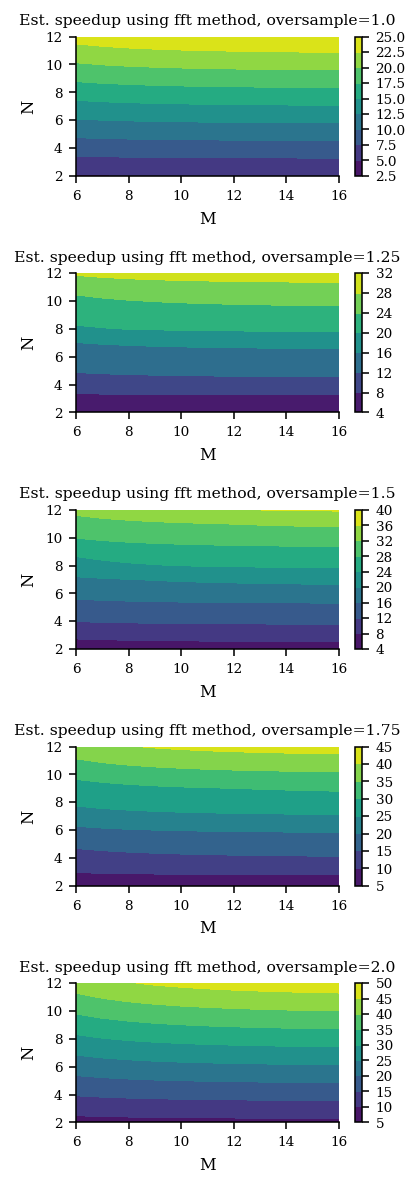

In [58]:
Ms = np.arange(6,17)
Ns = np.arange(2,13)
oversample = np.array([1,1.25,1.5,1.75,2])

direct_flops = np.zeros((Ms.size,Ns.size,oversample.size))
fft_flops = np.zeros((Ms.size,Ns.size,oversample.size))

for i, M in enumerate(Ms):
    for j, N in enumerate(Ns):
        for k, over in enumerate(oversample):
            Mnodes = int(M*over)
            Nnodes = int(N*over)

            direct_flops[i,j,k] = (M+1)**2*(2*N+1)*(Mnodes+1)**2*(2*Nnodes+1)
            fft_flops[i,j,k] = (2*N+1)*(M+1)**2*(Mnodes+1)**2 + (Mnodes+1)**2*(2*Nnodes+1)*np.log(2*Nnodes+1)

speedup = direct_flops / fft_flops

fig, ax = plt.subplots(oversample.size, figsize=(3,10))
for i, over in enumerate(oversample):
    im = ax[i].contourf(Ms,Ns,speedup[:,:,i].T)
    ax[i].set_xlabel('M')
    ax[i].set_ylabel('N')
    ax[i].set_title('Est. speedup using fft method, oversample={}'.format(over),fontsize=8)
    plt.colorbar(im,ax=ax[i])
    
plt.subplots_adjust(hspace=.7)

In [34]:
help(plt.contourf)

Help on function contourf in module matplotlib.pyplot:

contourf(*args, data=None, **kwargs)
    Plot contours.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == M`` is the number of columns in *Z* and
        ``len(Y) == N`` is the number of rows in *Z*.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(M)``, ``Y = range(N)``.
    
    Z : array-like(N, M)
        The height values over which the contour is drawn.
    
    levels : int or array-like, option